![risk](https://img.freepik.com/premium-vector/risk-obesity-medical-healthcare-with-fat-big-size-man-woman-with-obesity-bmi-meter-health-poster-infographic-hospital-clinic-doctor_518935-245.jpg)

# Obesity Risk

The dataset in Kaggle Playground Series S4E2 focuses on predicting obesity risk using a multi-class classification approach. Participants are tasked with building models that can classify individuals into different obesity risk categories based on features such as age, gender, height, weight, and lifestyle habits like physical activity and eating patterns.

**Key points of the dataset:**
Multi-Class Target: The dataset's target variable is "NObeyesdad," which indicates various levels of obesity and weight conditions such as Insufficient Weight, Normal Weight, Overweight, and different types of Obesity.


Features: The dataset includes both numerical features like age, height, weight, as well as categorical features such as gender and transportation methods.

Objective: The main goal is to create a model that can accurately predict which category of obesity an individual belongs to, based on their input features.


# Import Libraries

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 21.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [7]:
def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)



In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [9]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


In [11]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [12]:
def plot_categorical(dataframe, categorical_columns):
    num_cols = len(categorical_columns)
    num_rows = num_cols
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        # Countplot
        sns.countplot(x=col, data=dataframe, ax=axes[2*i], palette='tab10', hue=None)
        axes[2*i].set_title(f'{col} Count')
        axes[2*i].set_xlabel(col)
        axes[2*i].set_ylabel('Count')

        # Pieplot
        dataframe[col].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[2*i+1])
        axes[2*i+1].set_title(f'{col} Distribution')
        axes[2*i+1].set_ylabel('')

    plt.tight_layout()
    plt.show()


def plot_categorical_with_target_mean(dataframe, categorical_columns, target):
    num_cols = len(categorical_columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))

    if num_cols == 1:
        axes = [axes]  # Tek bir kategorik sütun varsa listeye dönüştür

    for i, col in enumerate(categorical_columns):
        # Gruplama işlemi ve ortalama hesaplama
        target_mean = dataframe.groupby(col)[target].mean()
        summary_df = pd.DataFrame({"TARGET_MEAN": target_mean})

        # Kategorik sütun için barplot (Ortalama hedef)
        summary_df.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Mean {target} by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(f'Mean {target}')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

        # Ortalamaları yazdırma
        for j, mean in enumerate(target_mean):
            axes[i].text(j, mean, f'{mean:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



def plot_histograms(dataframe, numeric_columns):
    num_cols = len(numeric_columns)
    num_rows = (num_cols + 2) // 3  # Her satırda 3 sütun olacak şekilde hesaplama
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))  # 4 yerine 3 sütun olacak şekilde ayarlandı
    axes = axes.flatten()

    for i, col in enumerate(numeric_columns):
        dataframe[col].hist(ax=axes[i], bins=20)  # Boyutu küçültmek için bins değerini azalttık
        axes[i].set_title(col, fontsize=18)
        axes[i].set_xlabel(col, fontsize=16)
        axes[i].set_ylabel('Frequency', fontsize=16)

    for j in range(num_cols, num_rows * 3):
        fig.delaxes(axes[j])  # Eğer sütun sayısı 3'e tam bölünmüyorsa fazlalık eksenleri kaldır

    plt.tight_layout()
    plt.show()


def target_summary_with_all_num_visualized(dataframe, numerical_cols, target):
    for numerical_col in numerical_cols:
        # Hedef değişkenin her bir kategorisi için sayısal sütunun ortalamasını hesaplama
        grouped_data = dataframe.groupby(target)[numerical_col].mean().reset_index()

        # Veriyi görselleştirme için pastel renklerde bir çubuk grafik oluşturma
        plt.figure(figsize=(5, 5))
        sns.barplot(x=target, y=numerical_col, data=grouped_data, palette='tab10', hue=None)
        plt.title('Mean ' + numerical_col + ' by ' + target)
        plt.xlabel(target)
        plt.ylabel('Mean ' + numerical_col)
        plt.xticks(rotation=1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Ortalamaları konsola yazdırma
        print(dataframe.groupby(target).agg({numerical_col: "mean"}))

In [13]:
def data_prep(dataframe):

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=25)
    cat_cols = [col for col in cat_cols if "NObeyesdad" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    num_cols = [col for col in num_cols if "NObeyesdad" not in col]

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)



    train_df = df[df['NObeyesdad'].notnull()]
    test_df = df[df['NObeyesdad'].isnull()]


    y = train_df['NObeyesdad']
    X = train_df.drop(["id", "NObeyesdad"], axis=1)

    return X,y

In [14]:
# Base Models
def base_models(X, y, cv=5):
    print("Base Models....")
    classifiers = [#('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   #('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                    ('CatBoost', CatBoostClassifier(verbose=False)),
                   ]


    scoring = ['accuracy', 'precision_macro', 'recall_macro']


    for name, classifier in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"Model: {name}")
        print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"Precision: {round(cv_results['test_precision_macro'].mean(), 4)}")
        print(f"Recall: {round(cv_results['test_recall_macro'].mean(), 4)}")
        print("\n")




In [15]:
def train_test(X, y, test_size=0.20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print("Base Models....")
    classifiers = [  #('LR', LogisticRegression()),
         ('KNN', KNeighborsClassifier()),
         ("SVC", SVC()),
        ("CART", DecisionTreeClassifier(random_state=0)),
        ("RF", RandomForestClassifier(random_state=0, max_features='sqrt')),
        # ('Adaboost', AdaBoostClassifier(random_state=0)),
         ('GBM', GradientBoostingClassifier(max_depth=4,random_state=0)),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('LightGBM', LGBMClassifier(random_state=0, verbose=-1)),
        ('CatBoost', CatBoostClassifier(verbose=False))
    ]
    print(classifiers)
    return X_train, X_test, y_train, y_test, classifiers

def models(classfiers, X, y):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
        # Calculating Cross-Validation scores for different metrics
        accuracy_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='accuracy',n_jobs=-1).mean()
        f1_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='f1',n_jobs=-1).mean()
        precision_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='precision',n_jobs=-1).mean()
        recall_cv = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='recall',n_jobs=-1).mean()

        # Printing Cross-Validation scores
        print(f"Classifier: {name}")
        print("Cross Validation Scores:")
        print("Accuracy : ", '{0:.2%}'.format(accuracy_cv))
        print("F1 : ", '{0:.2%}'.format(f1_cv))
        print("Precision : ", '{0:.2%}'.format(precision_cv))
        print("Recall : ", '{0:.2%}'.format(recall_cv))

        # Accuracy on test data
        test_accuracy = accuracy_score(y_test, prediction)
        print("Test Accuracy : ", '{0:.2%}'.format(test_accuracy))

In [16]:
def model_evaluation(classifiers, X_test, y_test, X_train, y_train, class_names):
    for name, classifier in classifiers:
        classifier.fit(X_train, y_train)
        cm = confusion_matrix(y_test, classifier.predict(X_test))

        # Sınıf isimlerini güncelliyoruz
        names = [f'Class {i}' for i in range(6)]
        counts = [value for value in cm.flatten()]
        percentages = [f'{(value / np.sum(cm)):.2%}' for value in cm.flatten()]

        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names * 6, counts, percentages)]
        labels = np.asarray(labels).reshape(6, 6)

        # Her sınıflandırıcı için ayrı bir grafik çiz
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=labels, cmap='Blues', fmt='', square=True)
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # Göster
        plt.show(block=True)

        # Sınıflandırma raporunu yazdır
        print(f'Classification Report for {name}:\n')
        print(classification_report(y_test, classifier.predict(X_test), target_names=class_names))


In [89]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):


    for name, clf in classifiers:
        print(f'\nClassifier: {name}')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Doğruluk (Accuracy) skoru
        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc:.4f}')

        # Sınıflandırma raporu
        print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

        # Karışıklık Matrisi
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()



In [18]:

def plot_feature_importances(classifiers, X_train, feature_names):
    for name, clf in classifiers:
        print(f'\nClassifier: {name}')

        # Feature importances özelliğine sahip olan sınıflandırıcılar için
        if hasattr(clf, 'feature_importances_'):
            clf.fit(X_train, y_train)
            importances = clf.feature_importances_

            # Feature importance değerlerini sıralı bir şekilde DataFrame'e koy
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)

            # Feature importances grafiği çiz
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title(f'Feature Importances for {name}')
            plt.show()

        # XGBoost ve LightGBM gibi bazı modellerin 'coef_' özelliği yok ancak farklı yöntemlerle feature importance sağlıyor
        elif hasattr(clf, 'coef_'):
            clf.fit(X_train, y_train)
            importances = np.abs(clf.coef_[0])

            # Feature importance değerlerini sıralı bir şekilde DataFrame'e koy
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)

            # Feature importances grafiği çiz
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title(f'Feature Importances for {name}')
            plt.show()

        else:
            print(f'{name} does not support feature importances.')



In [94]:
def hyperparameter_optimization(X_train, y_train, X_test, y_test, classifiers, cv=3,
                                scoring=['accuracy', 'precision_macro', 'recall_macro'], n_iter=10):
    print("Hyperparameter Optimization....")
    best_models = {}


    # Her sınıflandırıcı için hiperparametre optimizasyonu
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")

        # Optimizasyon öncesi cross-validation sonucu (X_train üzerinde)
        cv_results = cross_validate(classifier, X_train, y_train, cv=cv, scoring=scoring)
        print(f"Accuracy (Before): {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"Precision (Before): {round(cv_results['test_precision_macro'].mean(), 4)}")
        print(f"Recall (Before): {round(cv_results['test_recall_macro'].mean(), 4)}")

        # RandomizedSearchCV ile en iyi parametreleri bul
        rs_best = RandomizedSearchCV(classifier, param_distributions=params, n_iter=n_iter, cv=cv,
                                     n_jobs=-1, verbose=False, random_state=42).fit(X_train, y_train)

        # En iyi parametrelerle modeli yeniden ayarla
        final_model = classifier.set_params(**rs_best.best_params_)

        # Optimizasyon sonrası cross-validation sonucu (X_train üzerinde)
        cv_results = cross_validate(final_model, X_train, y_train, cv=cv, scoring=scoring)
        print(f"Accuracy (After): {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"Precision (After): {round(cv_results['test_precision_macro'].mean(), 4)}")
        print(f"Recall (After): {round(cv_results['test_recall_macro'].mean(), 4)}")
        print(f"{name} best params: {rs_best.best_params_}", end="\n\n")

        # En iyi modeli test seti üzerinde değerlendir
        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Test seti performansını yazdır
        print(f"{name} Test Set Performance:")
        print(f"Accuracy (Test Set): {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision (Test Set): {precision_score(y_test, y_pred, average='macro'):.4f}")
        print(f"Recall (Test Set): {recall_score(y_test, y_pred, average='macro'):.4f}", end="\n\n")

        # En iyi model kaydediliyor
        best_models[name] = final_model

    return best_models


# Functions for Feature Engineering

In [55]:
def feature(dataframe):
    # BMI hesaplama
    dataframe['BMI'] = dataframe['Weight'] / (dataframe['Height'] ** 2)

    # TUE sütunundaki 0 değerlerini 0.01 ile değiştirme
    dataframe['TUE'].replace(0, 0.01, inplace=True)

    # Yaş ve TUE oranı hesaplama
    dataframe['Age_TUE_Ratio'] = dataframe['Age'] / dataframe['TUE']

    # Kilo başına NCP hesaplama
    dataframe['Weight_per_NCP'] = dataframe['Weight'] / dataframe['NCP']

    # Mapping işlemi için sözlükler
    mapping = {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2,
        'Always': 3
    }

    mtrans_mapping = {
        'Public_Transportation': 0,
        'Automobile': 1,
        'Walking': 2,
        'Motorbike': 3,
        'Bike': 4
    }

    # Mapping işlemlerini uygulama
    dataframe['CALC'] = dataframe['CALC'].map(mapping)
    dataframe['CAEC'] = dataframe['CAEC'].map(mapping)
    dataframe['MTRANS'] = dataframe['MTRANS'].map(mtrans_mapping)

    # Fonksiyon sonunda dataframe'i döndürme
    return dataframe


In [69]:
def feature_add(dataframe):
  dataframe['BMI_Age_Ratio '] = dataframe['BMI'] / dataframe['Age']
  dataframe['Weight_Age_Ratio '] = dataframe['Weight'] / dataframe['Age']

  dataframe['FAF'].replace(0, 0.01, inplace=True)

  dataframe['Weight_FCVC_Adj'] = dataframe['Weight'] / dataframe['FCVC']
  dataframe['Weight_FAF_Adj'] = dataframe['Weight'] / dataframe['FAF']
  dataframe['Height_FCVC_Adj'] = dataframe['Height'] / dataframe['FCVC']
  dataframe['Height_FAF_Adj'] = dataframe['Height'] / dataframe['FAF']


  dataframe['FAF_FCVC_Ratio'] = dataframe['FAF'] / dataframe['FCVC']
  dataframe['FAF_Age_Ratio'] = dataframe['FAF'] / dataframe['Age']
  dataframe['FCVC_Age_Ratio'] = dataframe['FCVC'] / dataframe['Age']

  dataframe['FAF_FCVC_Poly'] = (dataframe['FAF'] ** 2) + (dataframe['FCVC'] ** 2)

  dataframe['CH2O_Weight_Ratio'] = dataframe['CH2O'] / dataframe['Weight']
  dataframe['CH2O_Height_Ratio'] = dataframe['CH2O'] / dataframe['Height']
  dataframe['CH2O_BMI'] = dataframe['CH2O'] / dataframe['BMI']

  # BMI kategorilerini oluşturma
  dataframe['BMI_Category'] = pd.cut(dataframe['BMI'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Ağırlık kategorilerini oluşturma
  dataframe['Weight_Category'] = pd.qcut(dataframe['Weight'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

  dataframe = dataframe.drop(['FAF', 'FCVC'], axis=1)

  return dataframe

# Main Functions

In [95]:
def main():
    # Load and preprocess the data
  train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/obesity_risk/train.csv')
  test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/obesity_risk/test.csv')
  df = pd.concat([train, test], sort=False)

  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    replace_with_thresholds(df, col)
  for col in num_cols:
    check_outlier(df, col)

  label_map = {"Insufficient_Weight": 0,
             "Normal_Weight": 1,
             "Obesity_Type_I": 2,
             "Obesity_Type_II": 3,
             "Obesity_Type_III": 4,
             "Overweight_Level_I": 5,
             "Overweight_Level_II": 6}

  df["NObeyesdad"] = df["NObeyesdad"].replace(label_map)
  df1 = df.copy()
  df1 = feature(df1)
  df1=feature_add(df1)
  X, y = data_prep(df1)
  X_train, X_test, y_train, y_test,classifiers = train_test(X,y)

  # Classifier listesi
  classifiers = [
    ('KNN', KNeighborsClassifier()),
    ("SVC", SVC()),
    ("CART", DecisionTreeClassifier()),
    ("RF", RandomForestClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier(verbose=False)),
  ]

  evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)


  # Özellik isimleri (X_train'deki sütun adları) ve classifier listesi
  feature_names = X_train.columns

  # Feature importance'ları çizdir
  plot_feature_importances(classifiers, X_train, feature_names)

    # Hiperparametre ayarları
  knn_params = {"n_neighbors": range(2, 20)}

  cart_params = {'max_depth': range(1, 10),
                "min_samples_split": range(2, 10)}

  rf_params = {"n_estimators": [100, 200],
              "max_depth": [5, 10, None],
              "min_samples_split": [2, 10],
              "min_samples_leaf": [1, 5]}

  xgboost_params = {"learning_rate": [0.05, 0.1],
                    "max_depth": [3, 5],
                    "n_estimators": [100, 200],
                    "colsample_bytree": [0.7, 1],
                    "subsample": [0.8, 1]}

  # Daraltılmış LightGBM parametreleri
  lightgbm_params = {"learning_rate": [0.05, 0.1],
                    "n_estimators": [100, 200],
                    "max_depth": [-1, 5],
                    "num_leaves": [31, 50],
                    "min_child_samples": [20, 50]}

  # Daraltılmış CatBoost parametreleri
  catboost_params = {"iterations": [200, 500],
                    "learning_rate": [0.05, 0.1],
                    "depth": [3, 5],
                    "l2_leaf_reg": [3, 5]}

  # Sınıflandırıcılar ve parametreleri
  classifiers = [
      ('KNN', KNeighborsClassifier(), knn_params),
      ("CART", DecisionTreeClassifier(), cart_params),
      ("RF", RandomForestClassifier(), rf_params),
      ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
      #('LightGBM', LGBMClassifier(), lightgbm_params),
      ('CatBoost', CatBoostClassifier(verbose=False), catboost_params)
  ]

  best_models = hyperparameter_optimization(X_train, y_train, X_test, y_test, classifiers)



<ipython-input-9-277dfb37a2bf>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17298.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


Base Models....
[('KNN', KNeighborsClassifier()), ('SVC', SVC()), ('CART', DecisionTreeClassifier(random_state=0)), ('RF', RandomForestClassifier(random_state=0)), ('GBM', GradientBoostingClassifier(max_depth=4, random_state=0)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, 

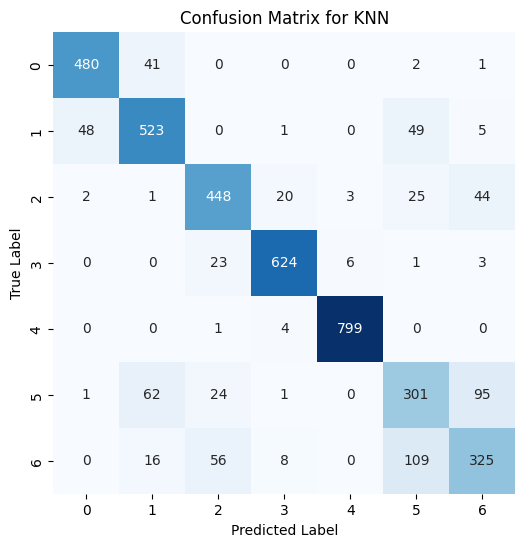


Classifier: SVC
Accuracy: 0.8810
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       524
         1.0       0.83      0.88      0.85       626
         2.0       0.87      0.84      0.85       543
         3.0       0.97      0.96      0.97       657
         4.0       1.00      1.00      1.00       804
         5.0       0.74      0.70      0.72       484
         6.0       0.75      0.77      0.76       514

    accuracy                           0.88      4152
   macro avg       0.87      0.87      0.87      4152
weighted avg       0.88      0.88      0.88      4152



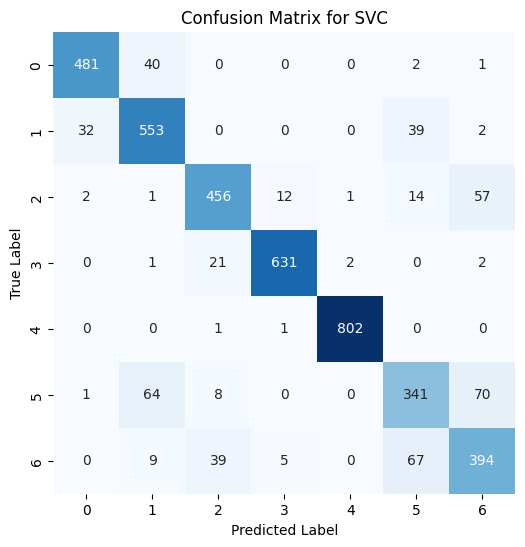


Classifier: CART
Accuracy: 0.8321
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       524
         1.0       0.77      0.77      0.77       626
         2.0       0.79      0.80      0.80       543
         3.0       0.96      0.95      0.95       657
         4.0       0.99      1.00      0.99       804
         5.0       0.63      0.66      0.64       484
         6.0       0.68      0.66      0.67       514

    accuracy                           0.83      4152
   macro avg       0.82      0.82      0.82      4152
weighted avg       0.83      0.83      0.83      4152



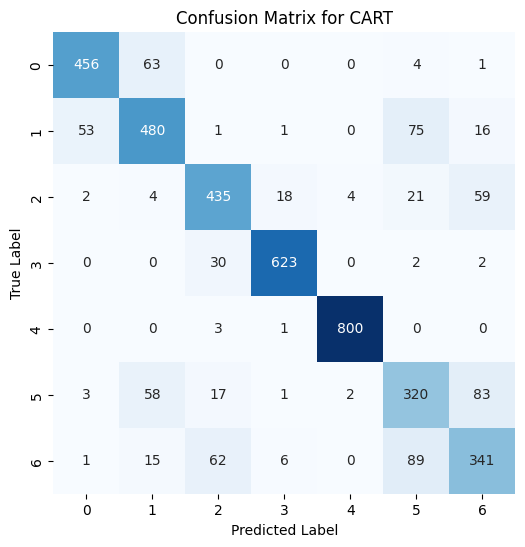


Classifier: RF
Accuracy: 0.8935
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       524
         1.0       0.85      0.86      0.85       626
         2.0       0.88      0.87      0.88       543
         3.0       0.98      0.97      0.97       657
         4.0       1.00      1.00      1.00       804
         5.0       0.76      0.76      0.76       484
         6.0       0.79      0.80      0.79       514

    accuracy                           0.89      4152
   macro avg       0.88      0.88      0.88      4152
weighted avg       0.89      0.89      0.89      4152



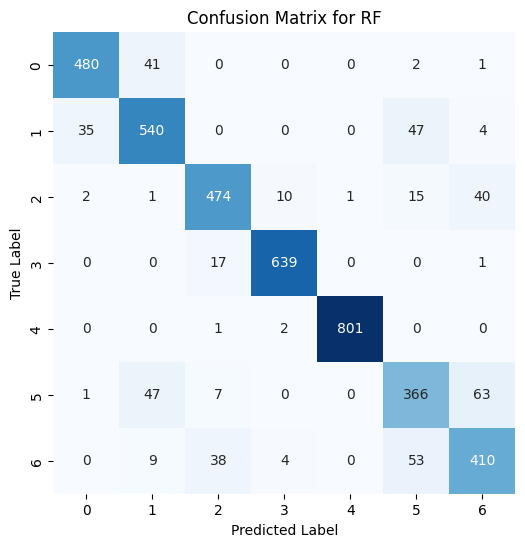


Classifier: GBM
Accuracy: 0.8981
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       524
         1.0       0.87      0.88      0.88       626
         2.0       0.88      0.87      0.87       543
         3.0       0.97      0.97      0.97       657
         4.0       1.00      1.00      1.00       804
         5.0       0.76      0.78      0.77       484
         6.0       0.79      0.78      0.79       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



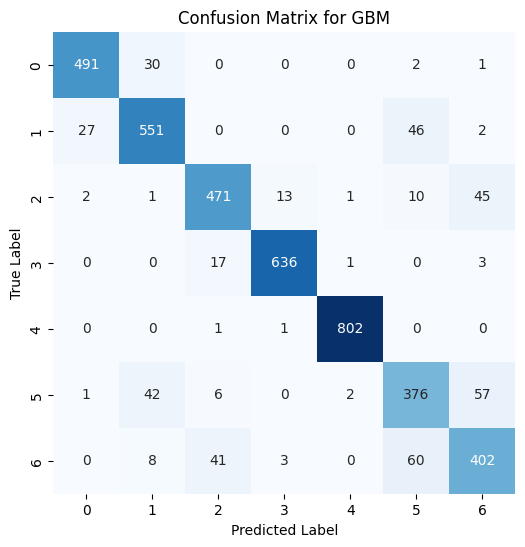


Classifier: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:21:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9017
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       524
         1.0       0.87      0.88      0.87       626
         2.0       0.88      0.87      0.87       543
         3.0       0.97      0.97      0.97       657
         4.0       1.00      1.00      1.00       804
         5.0       0.77      0.79      0.78       484
         6.0       0.81      0.80      0.81       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



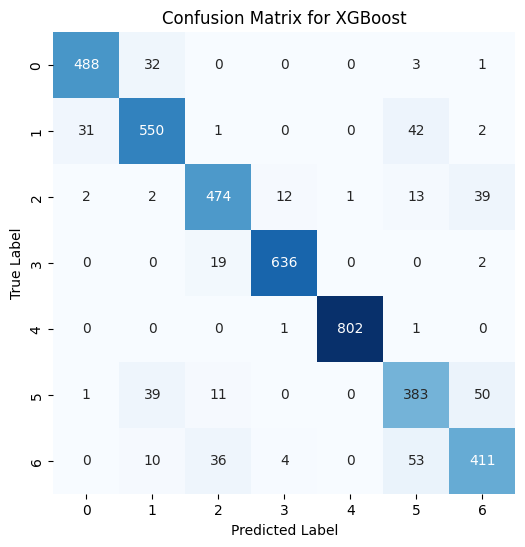


Classifier: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 38
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
Accuracy: 0.9008
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       524
         1.0       0.86      0.88      0.87       626
         2.0       0.88     

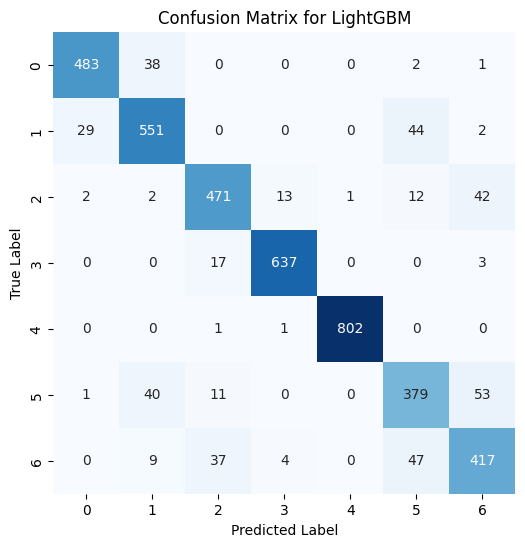


Classifier: CatBoost
Accuracy: 0.9080
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       524
         1.0       0.88      0.89      0.89       626
         2.0       0.88      0.89      0.89       543
         3.0       0.97      0.97      0.97       657
         4.0       1.00      1.00      1.00       804
         5.0       0.79      0.80      0.80       484
         6.0       0.81      0.80      0.81       514

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152



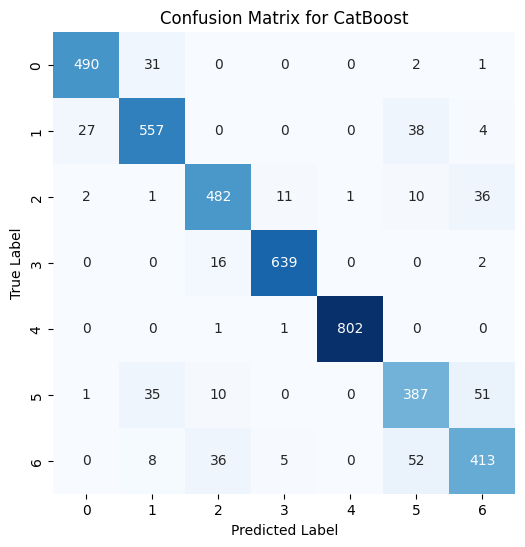


Classifier: KNN
KNN does not support feature importances.

Classifier: SVC
SVC does not support feature importances.

Classifier: CART


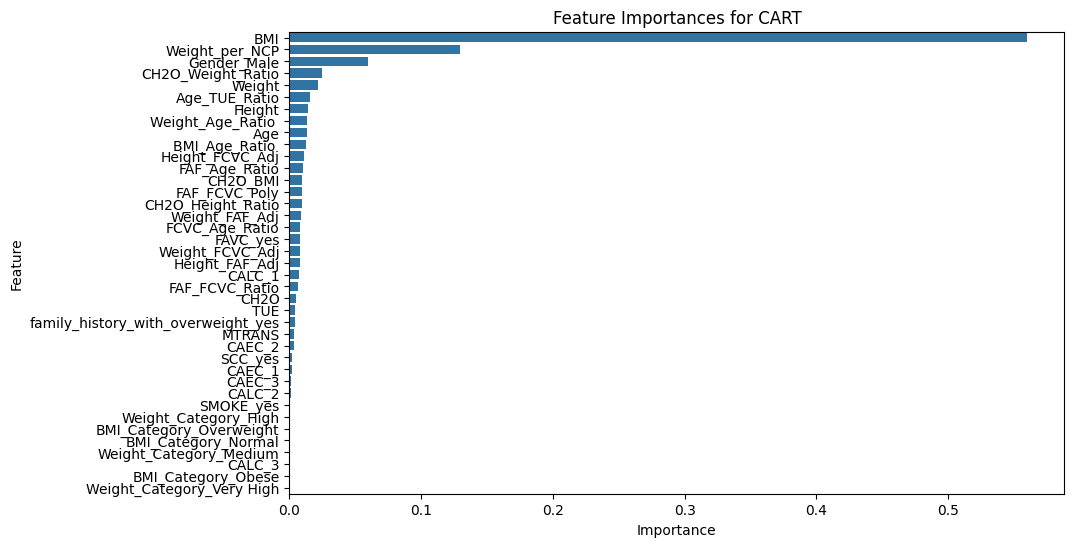


Classifier: RF


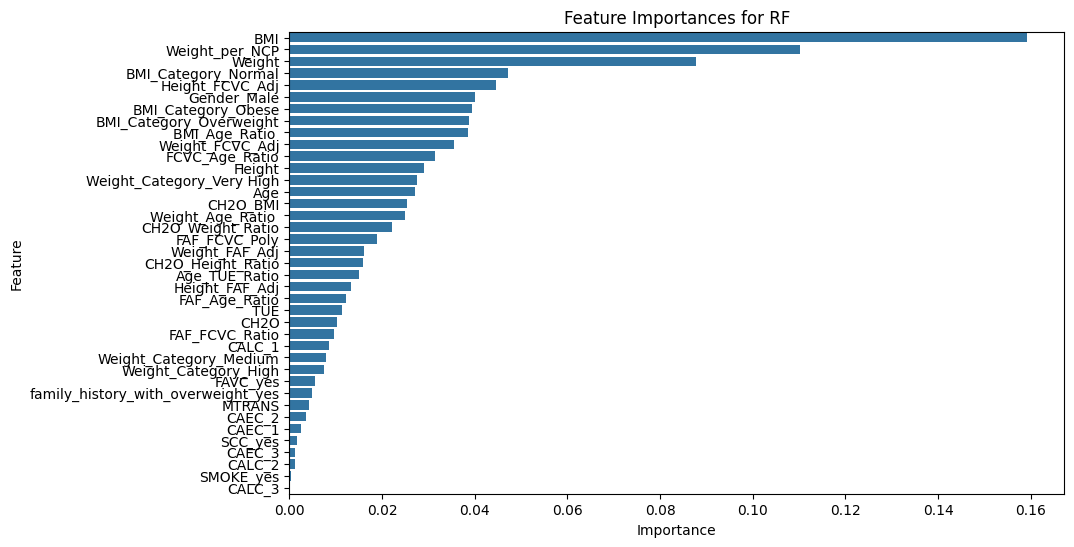


Classifier: GBM


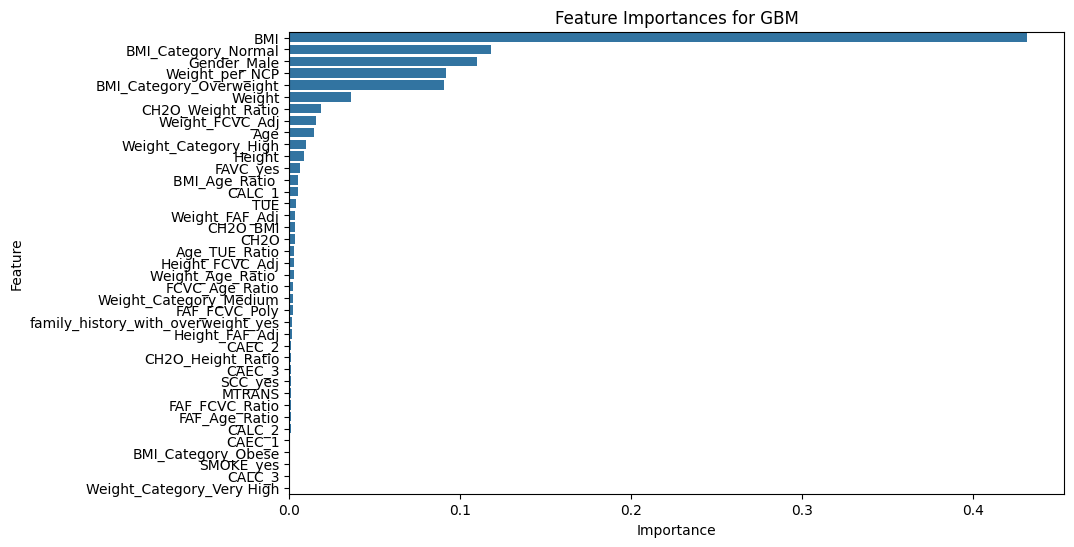


Classifier: XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:23:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


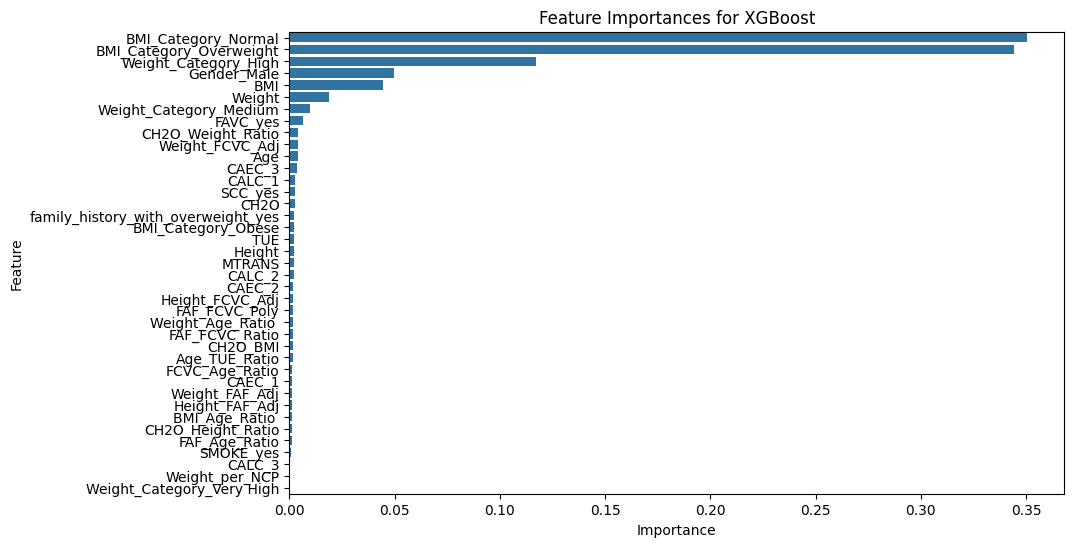


Classifier: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 38
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625


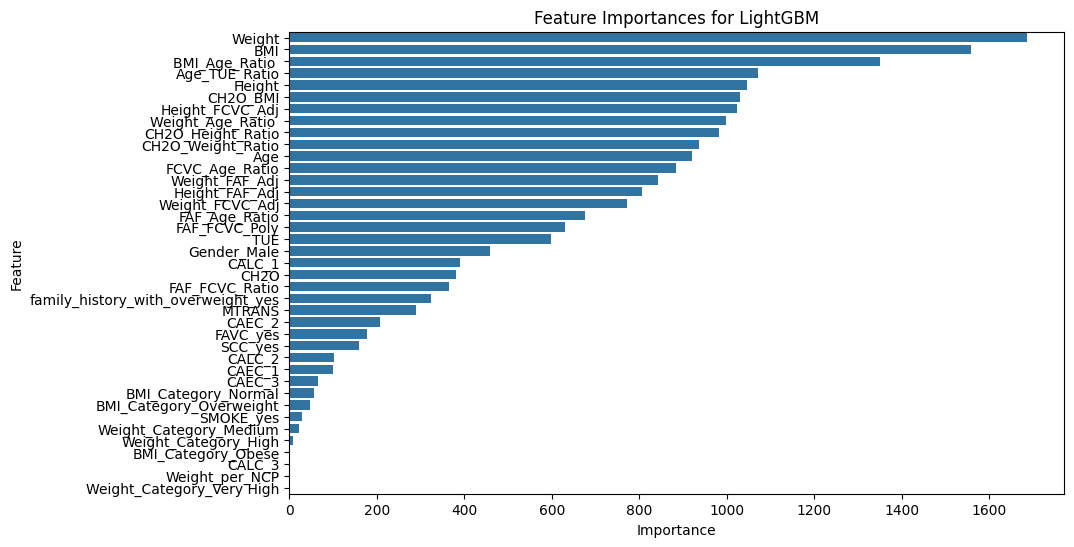


Classifier: CatBoost


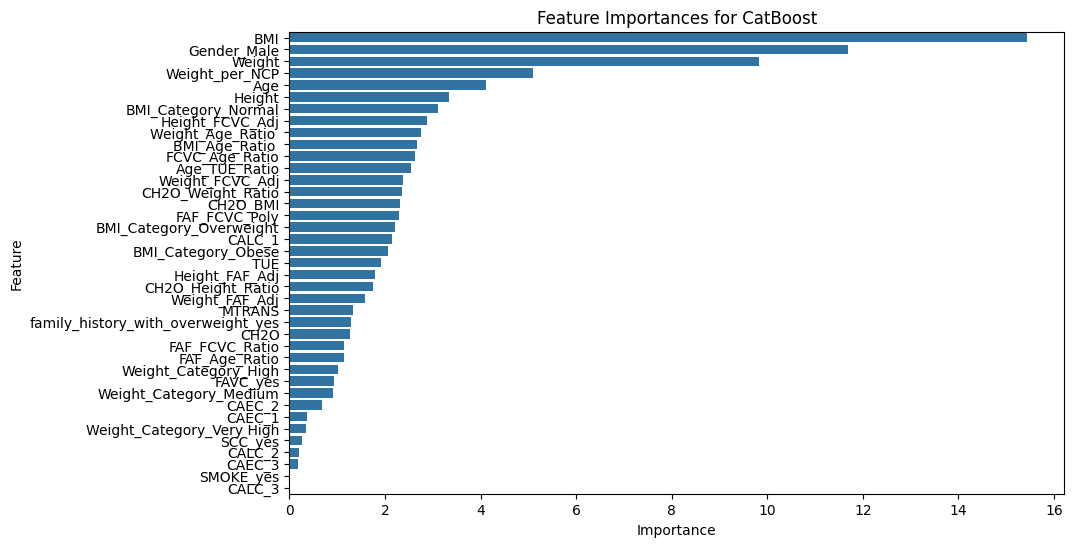

Hyperparameter Optimization....
########## KNN ##########
Accuracy (Before): 0.8411
Precision (Before): 0.8214
Recall (Before): 0.8229
Accuracy (After): 0.8426
Precision (After): 0.8231
Recall (After): 0.8249
KNN best params: {'n_neighbors': 13}

KNN Test Set Performance:
Accuracy (Test Set): 0.8434
Precision (Test Set): 0.8255
Recall (Test Set): 0.8258

########## CART ##########
Accuracy (Before): 0.8286
Precision (Before): 0.8124
Recall (Before): 0.8117
Accuracy (After): 0.8644
Precision (After): 0.8515
Recall (After): 0.8513
CART best params: {'min_samples_split': 8, 'max_depth': 8}

CART Test Set Performance:
Accuracy (Test Set): 0.8685
Precision (Test Set): 0.8562
Recall (Test Set): 0.8549

########## RF ##########
Accuracy (Before): 0.8861
Precision (Before): 0.8742
Recall (Before): 0.8739
Accuracy (After): 0.8865
Precision (After): 0.8745
Recall (After): 0.8744
RF best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

RF Test Set P

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Before): 0.8965
Precision (Before): 0.8858
Recall (Before): 0.8856


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (After): 0.8992
Precision (After): 0.8889
Recall (After): 0.8886
XGBoost best params: {'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:25:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Set Performance:
Accuracy (Test Set): 0.9051
Precision (Test Set): 0.8951
Recall (Test Set): 0.8945

########## CatBoost ##########
Accuracy (Before): 0.8972
Precision (Before): 0.8865
Recall (Before): 0.8863
Accuracy (After): 0.8968
Precision (After): 0.8861
Recall (After): 0.8858
CatBoost best params: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 5}

CatBoost Test Set Performance:
Accuracy (Test Set): 0.9020
Precision (Test Set): 0.8915
Recall (Test Set): 0.8916



In [96]:
if __name__ == "__main__":
    main()

# Conclusion

We added 10 different features to the dataset, which has a 7-class target variable. Using the CatBoost model, we achieved an average accuracy of 91% across all classes. Specifically, for the 5th and 6th target classes, we obtained an F1 score above 80%. We evaluated the impact of newly created features on all models through Feature Importance. The effects of these new categorical and numerical features were especially strong in the LightGBM and CatBoost models. During hyperparameter optimization, we used RandomSearch to calculate accuracy, precision, and recall metrics for four models. At this stage, we focused on stabilizing the model structure.






